In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import os
import shutil
import pathlib
import random

from PIL import Image

## Data Load

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"almachn","key":"dd87bb8cf78281719791cee826cb68db"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download dataset
!kaggle datasets download -d imbikramsaha/dog-breeds

# Ekstrak file zip
import zipfile

zip_path = '/content/dog-breeds.zip'
extract_path = '/content/dog-breeds'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Dataset URL: https://www.kaggle.com/datasets/imbikramsaha/dog-breeds
License(s): CC0-1.0
dog-breeds.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import os
from collections import defaultdict

dataset_path = '/content/dog-breeds'

class_counts = defaultdict(int)

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            class_name = os.path.basename(root)
            class_counts[class_name] += 1

for class_name, count in sorted(class_counts.items()):
    print(f"Class '{class_name}': {count} images")

print(f"\nTotal classes: {len(class_counts)}")
print(f"Total images: {sum(class_counts.values())}")

Class 'american_bulldog': 200 images
Class 'american_pit_bull_terrier': 200 images
Class 'basset_hound': 200 images
Class 'beagle': 200 images
Class 'boxer': 200 images
Class 'chihuahua': 200 images
Class 'english_cocker_spaniel': 200 images
Class 'english_setter': 200 images
Class 'german_shorthaired': 200 images
Class 'great_pyrenees': 200 images
Class 'havanese': 200 images
Class 'japanese_chin': 200 images
Class 'keeshond': 200 images
Class 'leonberger': 200 images
Class 'miniature_pinscher': 200 images
Class 'newfoundland': 200 images
Class 'pomeranian': 200 images
Class 'pug': 200 images
Class 'saint_bernard': 200 images
Class 'samoyed': 200 images
Class 'scottish_terrier': 199 images
Class 'shiba_inu': 200 images
Class 'staffordshire_bull_terrier': 191 images
Class 'wheaten_terrier': 200 images
Class 'yorkshire_terrier': 200 images

Total classes: 25
Total images: 4990


In [7]:
import pandas as pd
import os

dataset_path = '/content/dog-breeds/dog-breeds'

data = []
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            data.append({
                'image': img_path,
                'label': class_name
            })

df = pd.DataFrame(data)
print(df.head())

                                               image     label
0  /content/dog-breeds/dog-breeds/havanese/havane...  havanese
1  /content/dog-breeds/dog-breeds/havanese/havane...  havanese
2  /content/dog-breeds/dog-breeds/havanese/havane...  havanese
3  /content/dog-breeds/dog-breeds/havanese/havane...  havanese
4  /content/dog-breeds/dog-breeds/havanese/havane...  havanese


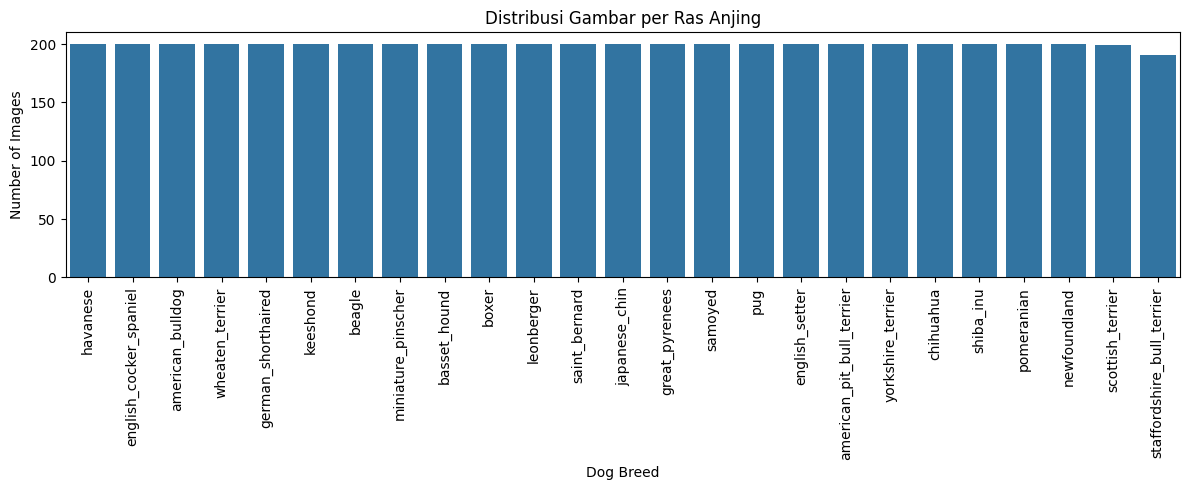

In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

plt.figure(figsize=(12, 5))
ax = sns.countplot(x=df.label, order=df['label'].value_counts().index)
ax.set_xlabel("Dog Breed")
ax.set_ylabel("Number of Images")
plt.xticks(rotation=90)
plt.title("Distribusi Gambar per Ras Anjing")
plt.tight_layout()
plt.show()

In [9]:
from pathlib import Path
import pandas as pd

dataset_path = Path("/content/dog-breeds")

image_paths = list(dataset_path.rglob("*.jpg"))
df = pd.DataFrame({
    'image': [str(p) for p in image_paths],
    'label': [p.parent.name for p in image_paths]
})

In [10]:
print(df.head())

                                               image     label
0  /content/dog-breeds/dog-breeds/havanese/havane...  havanese
1  /content/dog-breeds/dog-breeds/havanese/havane...  havanese
2  /content/dog-breeds/dog-breeds/havanese/havane...  havanese
3  /content/dog-breeds/dog-breeds/havanese/havane...  havanese
4  /content/dog-breeds/dog-breeds/havanese/havane...  havanese


In [11]:
print(df['label'].unique())

['havanese' 'english_cocker_spaniel' 'american_bulldog' 'wheaten_terrier'
 'staffordshire_bull_terrier' 'german_shorthaired' 'beagle' 'keeshond'
 'miniature_pinscher' 'basset_hound' 'leonberger' 'saint_bernard'
 'japanese_chin' 'great_pyrenees' 'samoyed' 'pug' 'english_setter' 'boxer'
 'yorkshire_terrier' 'chihuahua' 'shiba_inu' 'american_pit_bull_terrier'
 'newfoundland' 'pomeranian' 'scottish_terrier']


label
havanese                      200
english_cocker_spaniel        200
american_bulldog              200
wheaten_terrier               200
german_shorthaired            200
keeshond                      200
beagle                        200
miniature_pinscher            200
basset_hound                  200
boxer                         200
leonberger                    200
saint_bernard                 200
japanese_chin                 200
great_pyrenees                200
samoyed                       200
pug                           200
english_setter                200
american_pit_bull_terrier     200
yorkshire_terrier             200
chihuahua                     200
shiba_inu                     200
pomeranian                    200
newfoundland                  200
scottish_terrier              199
staffordshire_bull_terrier    191
Name: count, dtype: int64


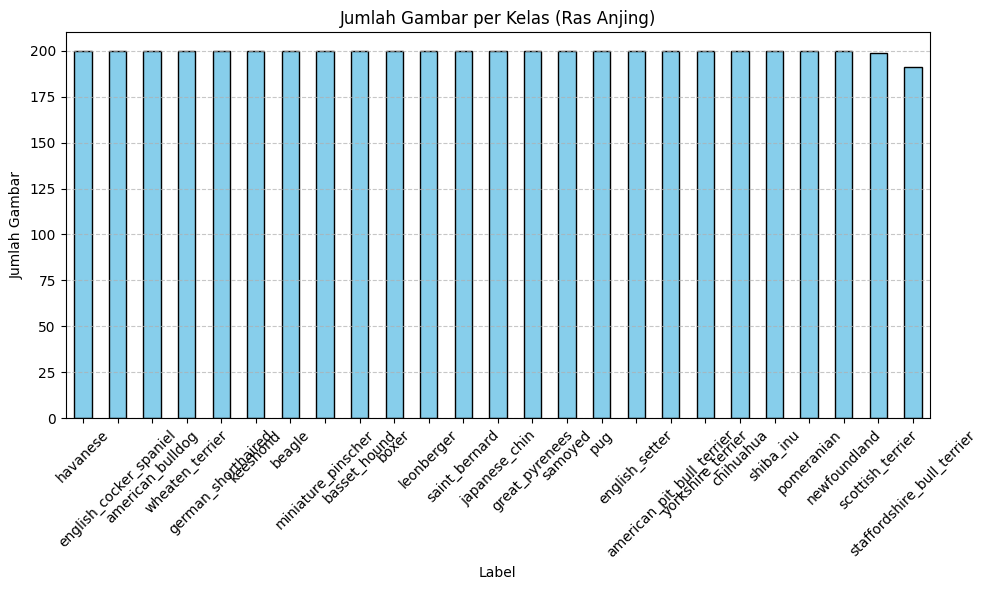

In [12]:
# Hitung jumlah sampel per label
label_counts = df['label'].value_counts()

# Print detail jumlah per label
print(label_counts)

# Visualisasi
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Jumlah Gambar per Kelas (Ras Anjing)')
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Modeling

In [13]:
from pathlib import Path
import pandas as pd

dataset_path = Path("/content/dog-breeds")
image_paths = list(dataset_path.rglob("*.jpg"))

df = pd.DataFrame({
    'image': [str(p) for p in image_paths],
    'label': [p.parent.name for p in image_paths]
})

In [14]:
df_trainval, df_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
df_train, df_val = train_test_split(df_trainval, test_size=0.2, stratify=df_trainval['label'], random_state=42)

print("Train:", df_train.shape)
print("Val:", df_val.shape)
print("Test:", df_test.shape)

Train: (3193, 2)
Val: (799, 2)
Test: (998, 2)


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
CLASS_MODE = 'categorical'
TARGET_CLASSES = df['label'].nunique()

train_gen = train_datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE
)

val_gen = val_datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE
)

Found 3193 validated image filenames belonging to 25 classes.
Found 799 validated image filenames belonging to 25 classes.


In [16]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # Freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(TARGET_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [17]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 770ms/step - accuracy: 0.0436 - loss: 4.3535 - val_accuracy: 0.1615 - val_loss: 2.9185 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 810ms/step - accuracy: 0.1208 - loss: 3.4487 - val_accuracy: 0.3742 - val_loss: 2.3273 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 823ms/step - accuracy: 0.1971 - loss: 2.9717 - val_accuracy: 0.5056 - val_loss: 1.8901 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 725ms/step - accuracy: 0.2888 - loss: 2.5075 - val_accuracy: 0.5970 - val_loss: 1.5864 - learning_rate: 1.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 704ms/step - accuracy: 0.3527 - loss: 2.2724 - val_accuracy: 0.6433 - val_loss: 1.3590 - learning_rate: 1.0000e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 810ms/step - accuracy: 0.4076 - loss: 2.0322 - val_accuracy: 0.6909 - val_loss: 1.1944 - learning_rate: 1.0000e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 71

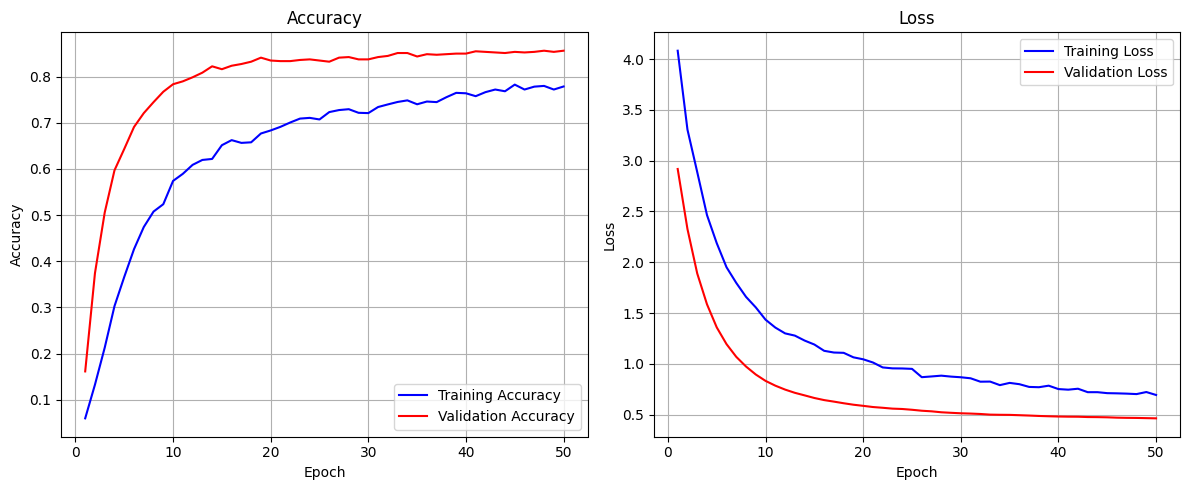

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Grafik Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Save Models

In [21]:
!pip install tensorflowjs

In [35]:
import tensorflow as tf
import os

save_dir = 'save_model/saved_model'
os.makedirs(save_dir, exist_ok=True)

tf.saved_model.save(model, os.path.join(save_dir, 'savedmodel'))
print("[✓] Model disimpan dalam format SavedModel")

[✓] Model disimpan dalam format SavedModel


In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(os.path.join(save_dir, 'model.tflite'), 'wb') as f:
    f.write(tflite_model)
print("[✓] Model disimpan dalam format TensorFlow Lite (.tflite)")

Saved artifact at '/tmp/tmpuozpyxo6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_157')
Output Type:
  Dict[['output_0', TensorSpec(shape=(None, 25), dtype=tf.float32, name=None)]]
Captures:
  138607443051344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138607443050768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138607443050576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138607443051152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138607443050960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138607438937936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138607438937360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138607438937168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138607438937744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138607438937552: TensorSpec(shape=(), dtype=tf.resource, na

In [37]:
!tensorflowjs_converter --input_format=tf_saved_model \
    {os.path.join(save_dir, 'savedmodel')} \
    {os.path.join(save_dir, 'tfjs_model')}
print("[✓] Model disimpan dalam format TensorFlow.js (tfjs_model/)")

2025-05-30 05:20:30.546294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748582430.583422   43648 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748582430.599792   43648 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-30 05:20:38.808878: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1748582440.348321   43648 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [43]:
class_names = sorted(df['label'].unique())

label_path = os.path.join(save_dir, 'labels.txt')
with open(label_path, 'w') as f:
    for label in class_names:
        f.write(label + '\n')
print(f"[✓] Label disimpan di: {label_path}")

[✓] Label disimpan di: save_model/saved_model/labels.txt


## Inference

Save Model

In [52]:
img_path = input("Masukkan path gambar untuk prediksi: ")
predicted_label, confidence = predict_savedmodel(img_path, model, class_names)

def load_and_preprocess_image(img_path, img_size=(128, 128)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def predict_savedmodel(img_path, model, class_names, img_size=(128, 128)):
    img_array = load_and_preprocess_image(img_path, img_size)
    preds = model.predict(img_array)

    output_array = preds['output_0']

    predicted_index = np.argmax(output_array[0])
    confidence = output_array[0][predicted_index]
    predicted_label = class_names[predicted_index]

    print(f"Prediksi: {predicted_label} dengan confidence {confidence:.2%}")
    return predicted_label, confidence

Masukkan path gambar untuk prediksi: /content/dog-breeds/dog-breeds/samoyed/samoyed_103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediksi: samoyed dengan confidence 98.54%


TF-Lite

In [53]:
img_path = input("Masukkan path gambar untuk prediksi: ")
predicted_label, confidence = predict_savedmodel(img_path, model, class_names)

def load_and_preprocess_image(img_path, img_size=(128, 128)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0).astype(np.float32)

def predict_tflite(img_path, tflite_model_path, class_names, img_size=(128, 128)):
    # Load TFLite model dan allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input dan output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Load dan preprocess image
    input_data = load_and_preprocess_image(img_path, img_size)

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Ambil output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_index = np.argmax(output_data[0])
    confidence = output_data[0][predicted_index]
    predicted_label = class_names[predicted_index]

    print(f"Prediksi: {predicted_label} dengan confidence {confidence:.2%}")
    return predicted_label, confidence

Masukkan path gambar untuk prediksi: /content/dog-breeds/dog-breeds/shiba_inu/shiba_inu_106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Prediksi: shiba_inu dengan confidence 99.45%


In [54]:
!pip freeze > requirements.txt